# Initalization 

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
from PIL import Image
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
tf.test.gpu_device_name()

''

In [2]:
import pathlib
data_dir = pathlib.Path(r'\Users\elife\Documents\Jupyter-Notebook\MaskClassification\CMFD-LowerRes') 
count = len(list(data_dir.glob('*/*.jpg')))
print(count)

3815


# Setting up for Training

In [3]:
#Resize image to make better
batch_size = 32
img_height = 256
img_width = 256

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3815 files belonging to 4 classes.
Using 3052 files for training.


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3815 files belonging to 4 classes.
Using 763 files for validation.


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [7]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


In [11]:
#Last layer can't be relu must be sigmoid
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Dropout(0.5),
    
  layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Dropout(0.25),
    
  layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Dropout(0.25),
    
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.125),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.125),
  layers.Dense(4, activation='softmax')
])    

opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [12]:

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 64, 64, 64)       

In [13]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)
print(history.history['accuracy'][epochs-1])
model.save("lowRes")

Epoch 1/5
96/96 [==============================] - 174s 2s/step - loss: 1.6504 - accuracy: 0.2527 - val_loss: 1.3863 - val_accuracy: 0.2831
Epoch 2/5
96/96 [==============================] - 200s 2s/step - loss: 1.3894 - accuracy: 0.2495 - val_loss: 1.3863 - val_accuracy: 0.2595
Epoch 3/5
96/96 [==============================] - 198s 2s/step - loss: 1.3855 - accuracy: 0.2432 - val_loss: 1.3863 - val_accuracy: 0.2503
Epoch 4/5
96/96 [==============================] - 193s 2s/step - loss: 1.3859 - accuracy: 0.2519 - val_loss: 1.3863 - val_accuracy: 0.2503
Epoch 5/5
96/96 [==============================] - 192s 2s/step - loss: 1.3845 - accuracy: 0.2820 - val_loss: 1.3864 - val_accuracy: 0.2451
0.2804718315601349
INFO:tensorflow:Assets written to: lowRes\assets


In [ ]:
np.save('my_history_lowRes.npy',history.history)

In [ ]:
history=np.load('my_history.npy',allow_pickle='TRUE').ite

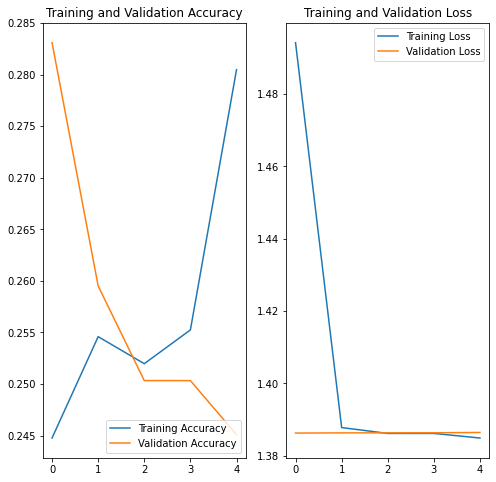

In [17]:

acc = history.history['accuracy']

val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()